# Finite element method: Poisson equation in 2D with Dirichlet boundary conditions

Consider the following problem:
$$
\left\{
\begin{aligned}
- \Delta u &= f \;  &\quad \text{in } \Omega = (0,1)^2 \\
u &= 0 \;  &\quad \text{on } \partial \Omega 
\end{aligned}
\right.
$$

Implement the numerical solution of this problem by using piecewise linear finite elements.

You are given different triangular meshes, which contain
 * a list $t$ of the elements ($n \times 3$ matrix),
 * a list $p$ of the vertices with $x$ and $y$ coordinates ($m \times 2$ matrix),
 * a list $r$ of the boundary points (vector).
 
Plot the meshes with the plotting function from the previous exercise.

For each element, calculate first the element stiffness matrix and the element load vector. Approximate the function $f$ by the value in the centroid of the element.

Test your implementation with the given exact solution 
$$
u(x,y) = \sin(\pi x) \sin(\pi y) \; .
$$

Calculate the errors on the different grids and produce a log-log-plot of the errors.

## Solution

By choosing linear finite elements, we have the following basis functions on the reference element $\hat K$, which is the triangle consisting of the vertices $(0,0)$, $(1,0)$ and $(0,1)$:
$$
\begin{align}
N_0(\xi) &= 1 - \xi_1 - \xi_2 \\
N_1(\xi) &= \xi_1 \\
N_2(\xi) &= \xi_2
\end{align}
$$

The entries of the element stiffness matrix for a element $K$ are given by
$$
(A_K)_{i,j} = \vert K \vert \cdot \nabla_\xi N_i \cdot J_K^{-1} \cdot  J_K^{-\mathrm T} \cdot  (\nabla_\xi N_j)^{\mathrm T} \; ,
$$
so the whole element stiffness matrix can be calculated by
$$
A_K = \vert K \vert \cdot \begin{bmatrix} -1 & -1 \\ 1 & 0 \\ 0 & 1 \end{bmatrix} \cdot J_K^{-1} \cdot J_K^{-\mathrm T} \cdot \begin{bmatrix} -1 & 1 & 0 \\ -1 & 0 & 1 \end{bmatrix} \; .
$$
$J_K$ is the Jacobian of the function $F_K$, which maps the reference element $\hat K$ to the element $K$.

The element load vector is given by 
$$
\ell_K = f(m_K) \cdot \vert J_K \vert \cdot \frac 1 6 \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} \; .
$$

Now we read in the meshes and plot them.

In [1]:
using MAT

tvals = []
pvals = []
rvals = []

for i = 1:6
    vars = matread(string("./ex8_data/mesh", i, ".mat"))
    name = string("mesh", i)
    tf = vars[name]["t"]
    push!(tvals, round.(Int64, tf))
    push!(pvals, vars[name]["p"])
    rf = vars[name]["r"]
    push!(rvals, round.(Int64, rf))
end

In [2]:
using PyPlot

using PyCall
@pyimport matplotlib as mpl

function plot_mesh(t, p, name; show_numbers=false)
    patches = mpl.pymember("patches")

    fig = figure(figsize=(8,8))#figsize=(15,10))
    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    pas = [patches.Polygon([p[i,:] for i=t[j,:]], closed=true, edgecolor="black", fill=false) for j=1:size(t)[1]]

    for (i, pa) in enumerate(pas)
        ax.add_patch(pa)
        if show_numbers
            coords = pa.get_xy()
            xc = (coords[1,1] + coords[2,1] + coords[3,1] ) / 3
            yc = (coords[1,2] + coords[2,2] + coords[3,2] ) / 3
            ax.annotate(string(i), (xc, yc), ha="center", va="center", fontsize=14)
            
        end
    end
    if show_numbers
        i = 1
        for (x,y) in zip(p[:,1], p[:,2])
                ax.annotate(string(i), (x, y), color="red", ha="left", va="bottom", fontsize=12)
                i += 1
        end
    end
    title(name)
    ax.plot()
end
;

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:407
└ @ PyCall /home/alex/.julia/packages/PyCall/a5Jd3/src/PyCall.jl:407


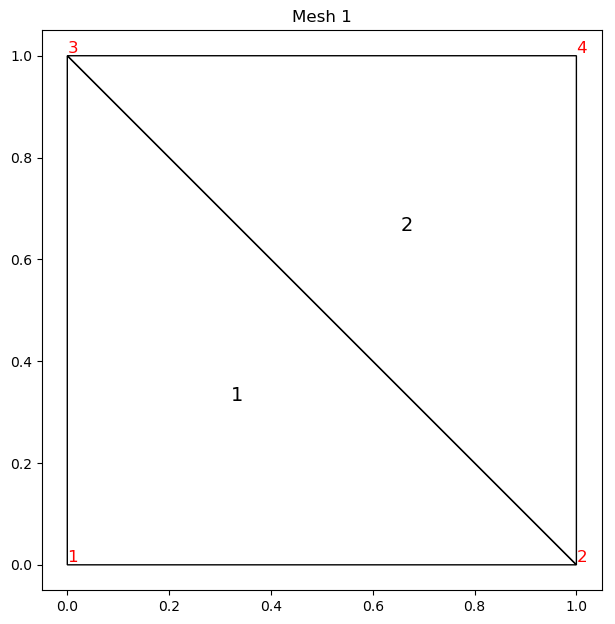

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = pymember at PyCall.jl:387 [inlined]
└ @ Core /home/alex/.julia/packages/PyCall/a5Jd3/src/PyCall.jl:387


In [3]:
plot_mesh(tvals[1], pvals[1], "Mesh 1", show_numbers=true);

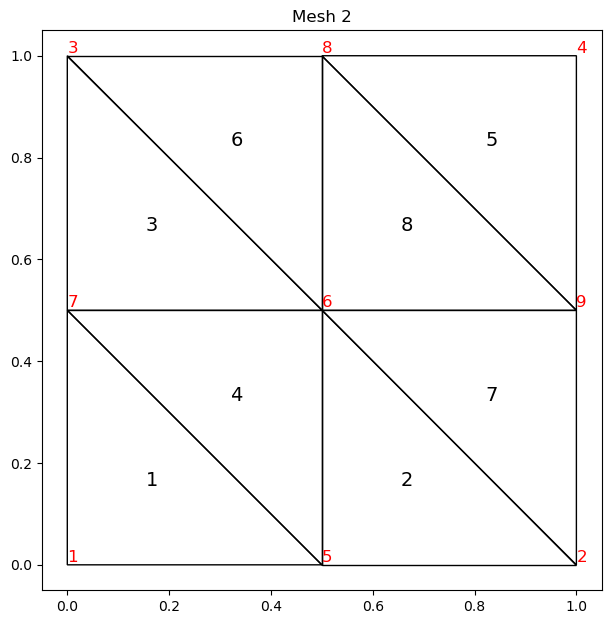

In [4]:
plot_mesh(tvals[2], pvals[2], "Mesh 2", show_numbers=true);

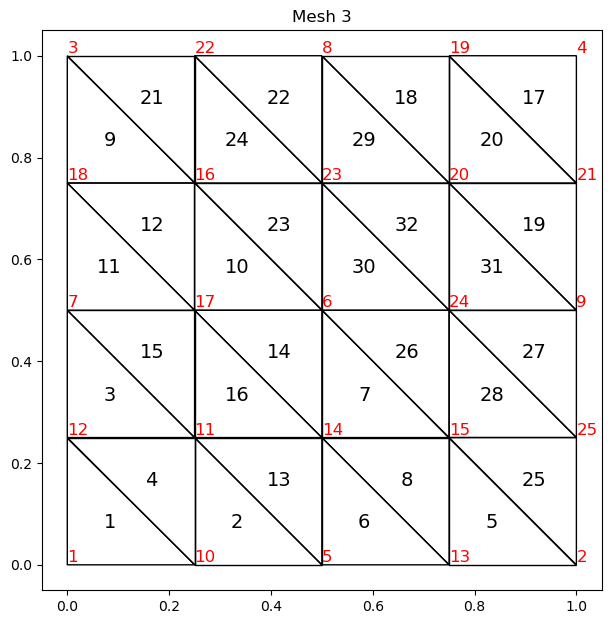

In [5]:
plot_mesh(tvals[3], pvals[3], "Mesh 3", show_numbers=true);

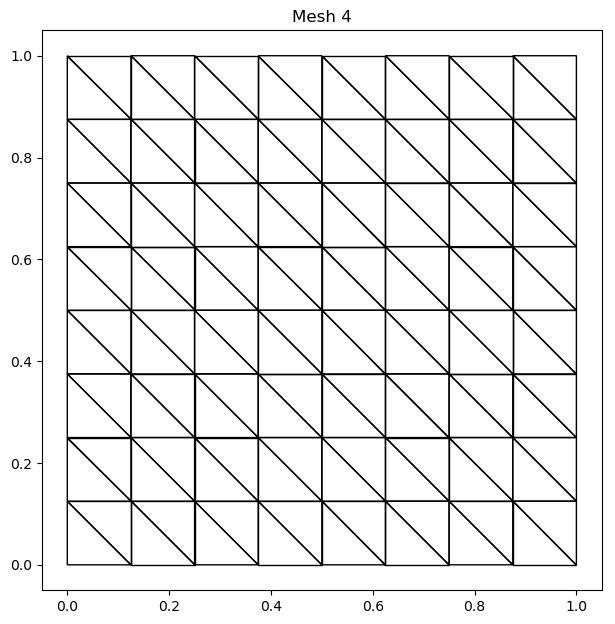

In [6]:
plot_mesh(tvals[4], pvals[4], "Mesh 4");

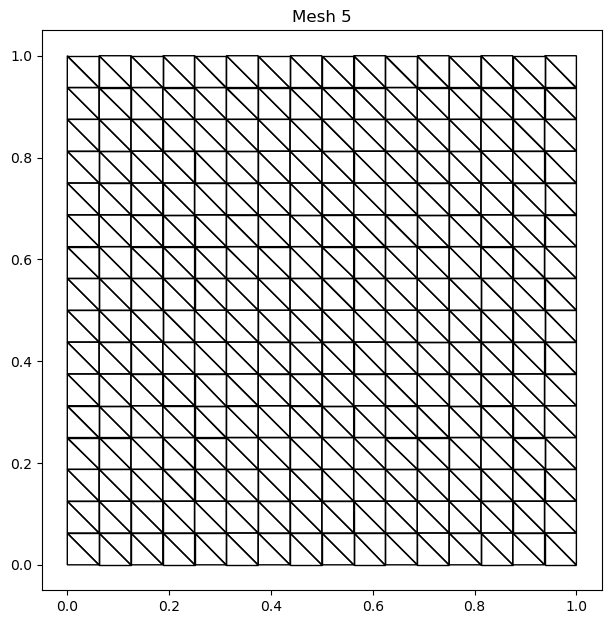

In [7]:
plot_mesh(tvals[5], pvals[5], "Mesh 5");

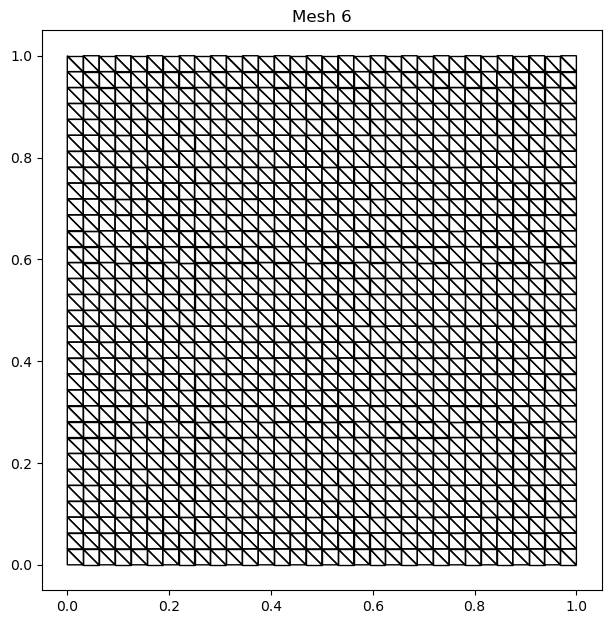

In [8]:
plot_mesh(tvals[6], pvals[6], "Mesh 6");

Let's write a code to assemble the element stiffness matrix and the element load vector.

In [9]:
using LinearAlgebra
function element_stiffness_matrix_load_vector(t, p, el, f)
    J = zeros(2,2)
    p0 = p[t[el, 1],:]
    p1 = p[t[el, 2],:]
    p2 = p[t[el, 3],:]
    J[:,1] = p1 - p0
    J[:,2] = p2 - p0
    invJ = inv(J)
    detJ = det(J)
    A = 0.5 * abs(detJ) * [-1 -1; 1 0; 0 1] * invJ * invJ' * [-1 1 0; -1 0 1]
    
    m = (p0 + p1 + p2) / 3
    l = f(m[1], m[2]) * abs(detJ) / 6 * [1;1;1]
    
    return A, l
end
;

The function $f$ is given by
$$
f(x,y) = 2 \pi^2 \sin(\pi x) \sin(\pi y) \; .
$$

In [10]:
f(x,y) = 2 * pi^2 * sin.(pi*x) .* sin.(pi*y);

In [11]:
using SparseArrays
function assemble_stiffness_matrix_load_vector(t, p, r, f)
    Nelements = size(t)[1]
    Npoints = size(p)[1]
    A = spzeros(Npoints, Npoints)
    l = zeros(Npoints)
    for el = 1:Nelements
        Ael, lel = element_stiffness_matrix_load_vector(t, p, el, f)
        for i = 1:3
            l[t[el,i]] += lel[i]
            for j = 1:3
                A[t[el, i], t[el, j]] += Ael[i,j]
            end
        end
    end
    
    # Set the Dirichlet boundary conditions:
    nzrow_ind, nzcol_ind, _ = findnz(A)
    for (i, j) in zip(nzrow_ind, nzcol_ind)
        if i in r
            if i == j
                A[i,j] = 1.0
            else
                A[i,j] = 0.0
            end 
        end
    end
    for i = 1:Npoints
        if i in r
            l[i] = 0.0
        end
    end
    
    return A, l
end
;

In [12]:
function solve(t, p, r, f)
    A, l = assemble_stiffness_matrix_load_vector(t, p, r, f)
    A \ l
end
;

We calculate the numerical solutions for these different meshes.

In [13]:
numerical_solutions = [solve(t, p, r, f) for (t, p, r) in zip(tvals, pvals, rvals)];

We calculate the exact solutions and evaluate the errors for the different meshes.

In [14]:
u(x,y) = sin.(pi*x) .* sin.(pi*y)
exact_solutions = [u(p[:,1], p[:,2]) for p in pvals]
errors = [maximum(abs, ex - num) for (ex, num) in zip(exact_solutions, numerical_solutions)]

6-element Array{Float64,1}:
 1.4997597826618576e-32
 0.33543619010570414   
 0.08525265485501943   
 0.021392569376596948  
 0.005352995081200351  
 0.0013385503821626843 

Note that there is no error on the coarsest mesh. That's because it consists only of boundary points.

We write a function to plot a solution.

In [15]:
using PyPlot
function plot_solution(x, y, numsol, tit)
    fig = figure("pyplot_surfaceplot",figsize=(8,8))
    PyPlot.using3D()
    ax = fig.add_subplot(1,1,1, projection = "3d")
    ax.plot_trisurf(x, y, numsol, linewidth=0, antialiased=false, cmap=get_cmap("inferno"))
    title(tit)
    xlabel("x")
    ylabel("y")
    
end

function plot_solution_contour(x, y, numsol, tit)
    fig = figure("pyplot_surfaceplot", figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    cp = ax.tricontour(x, y, numsol, colors="black")
    ax.clabel(cp, inline=1, fontsize=12)
    title(tit)
    xlabel("x")
    ylabel("y")
end
;

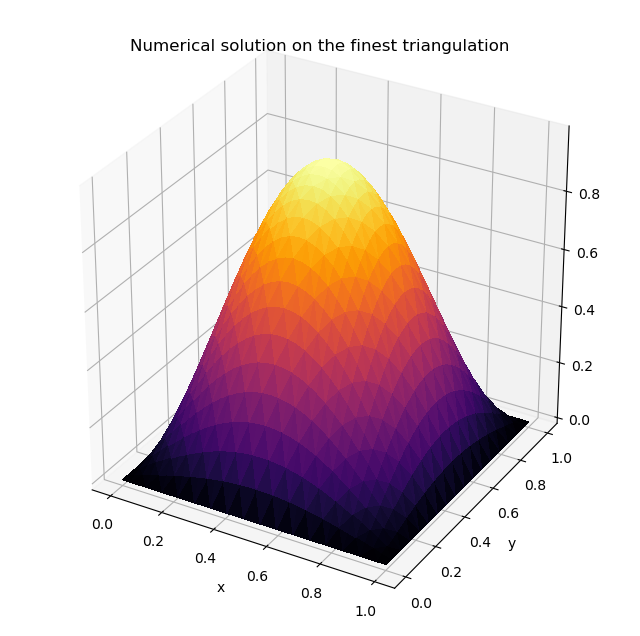

In [16]:
plot_solution(pvals[6][:,1], pvals[6][:,2], numerical_solutions[6], "Numerical solution on the finest triangulation");

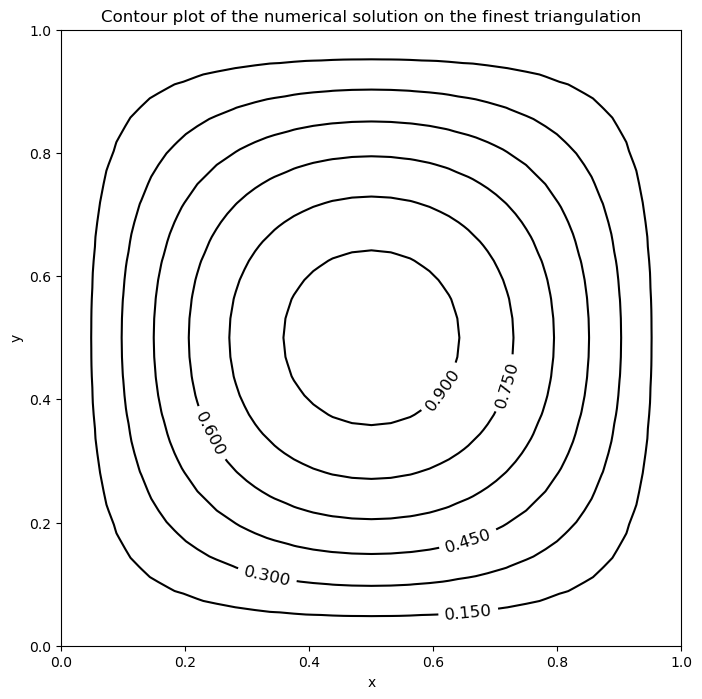

In [17]:
plot_solution_contour(pvals[6][:,1], pvals[6][:,2], numerical_solutions[6], "Contour plot of the numerical solution on the finest triangulation");

We calculate the mesh size of the triangular meshes by taking the longest side of all the triangles.

In [18]:
function get_mesh_size(t, p)
    h = 0.0
    for i = 1:length(size(t)[1])
        p0 = p[t[i, 1],:]
        p1 = p[t[i, 2],:]
        p2 = p[t[i, 3],:]

        l1 = norm(p0 - p1)
        l2 = norm(p1 - p2)
        l3 = norm(p2 - p0)
        
        ls = maximum([l1, l2, l3])
        if ls > h
            h = ls
        end
    end
    return h
end
;

In [19]:
mesh_sizes = [get_mesh_size(t, p) for (t, p) in zip(tvals, pvals)]

6-element Array{Float64,1}:
 1.4142135623730951 
 0.7071067811865476 
 0.3535533905932738 
 0.1767766952966369 
 0.08838834764831845
 0.04419417382415922

For the error plot, we will ignore the coarsest mesh, since it has no interior points.

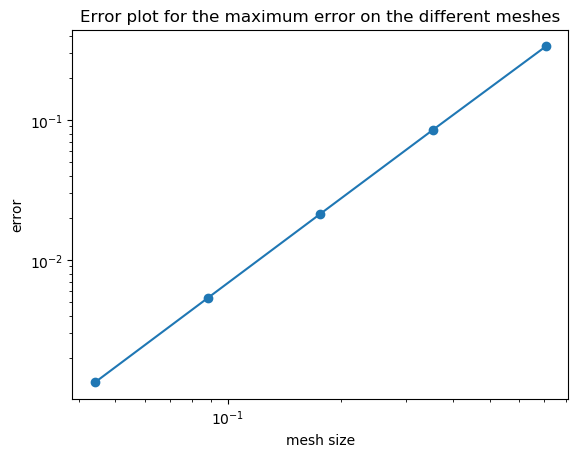

In [20]:
loglog(mesh_sizes[2:end], errors[2:end], "-o")
title("Error plot for the maximum error on the different meshes")
xlabel("mesh size")
ylabel("error");